In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch

from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad',
                               '--model-name', 'scNT_model_gat.cpt',
                               '--exp-name', 'CohAE_scNT_gat',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', None,
                               '--fit_offset_pred', 'True',
                               '--use_offset_pred', None, # we remove offset after low-dimensional linear regression with offset,
                                                          # to further denoise output, since during training we did not use offset 
                                                          # in order to make the low dimensions centered (i.e., offset = 0) for linear regression. So, Ideally, when fitting 
                                                          # linear regression with offset after training veloAE, the offset should be close to zero.
                                                          # But fitting with an offset may alow gamma to be less prone to noies.
                               '--use_gcn', None
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("0", "15"), ("15", "30"), ("30", "60"), ("60", "120")]
k_cluster = "time"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
adata.obs['time'] = adata.obs.time.astype('category')
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
Filtered out 39141 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3066 × 2000
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:08) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scNT_stochastical.png


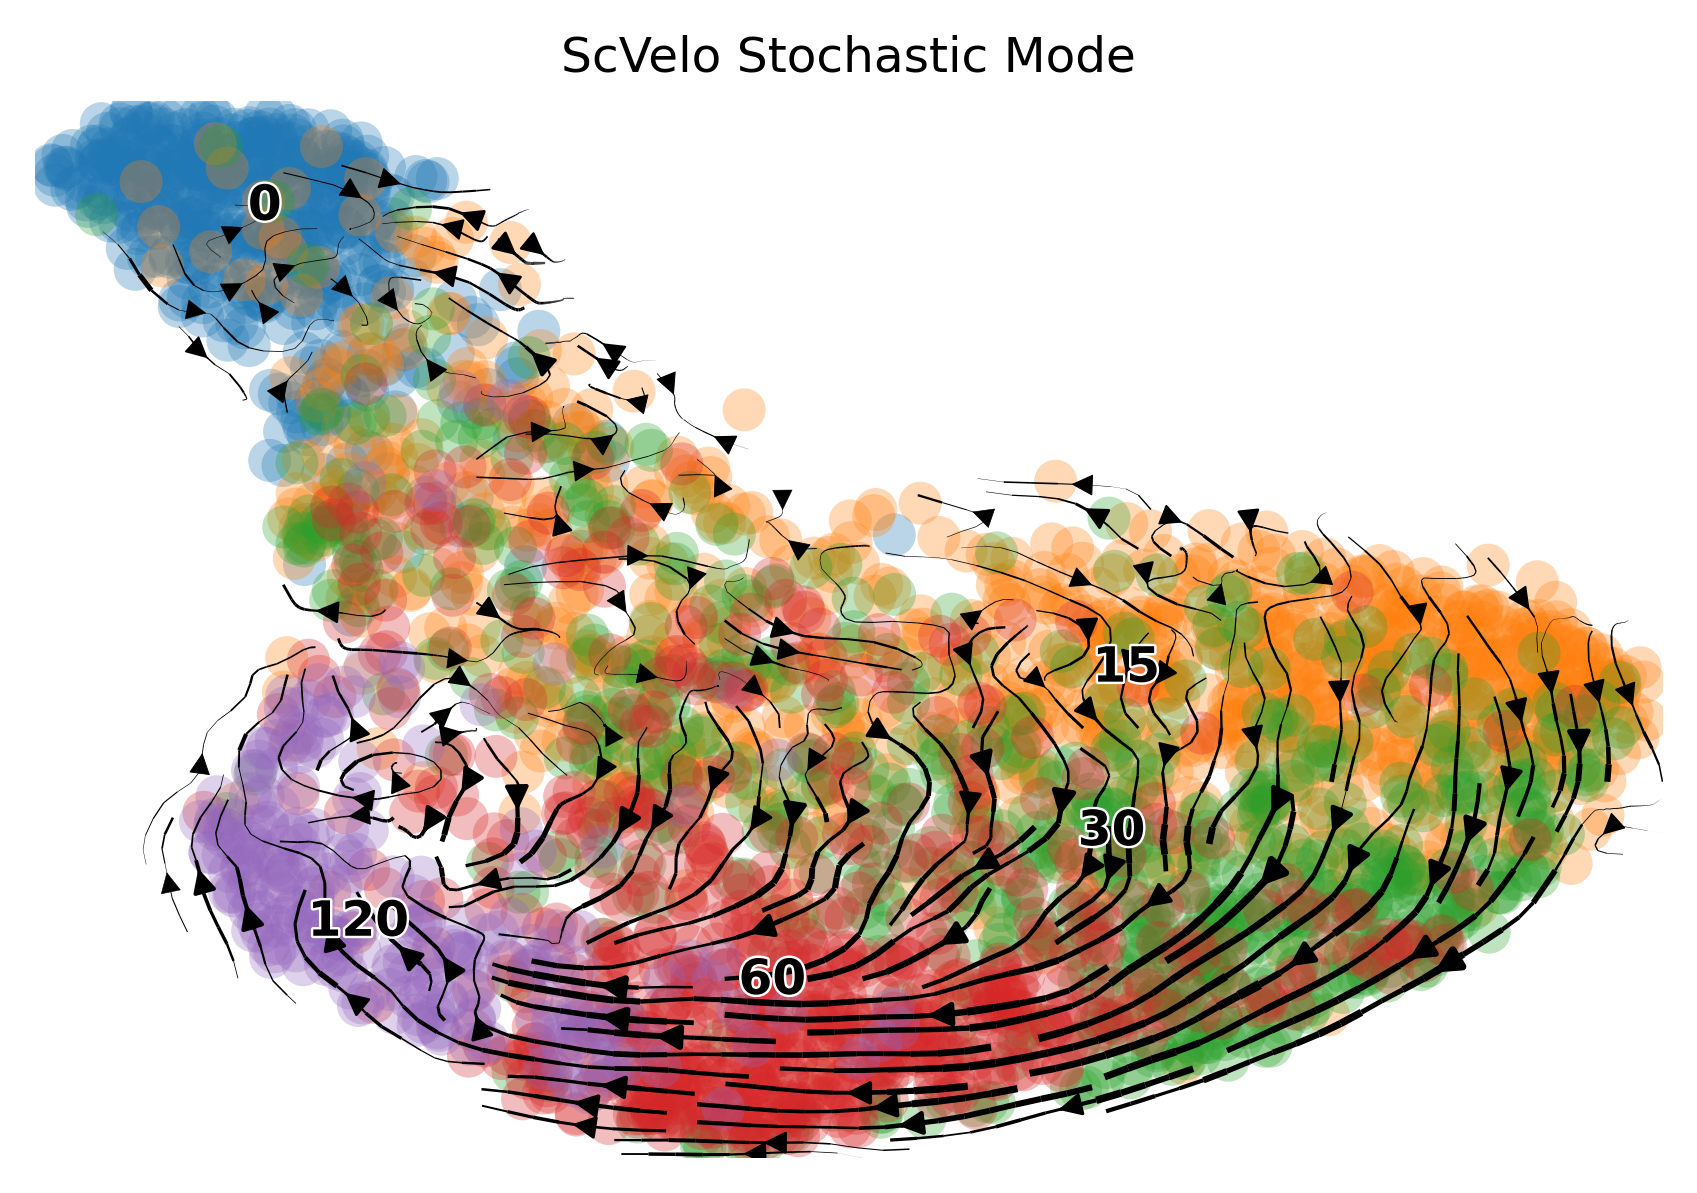

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.18047157, ('15', '30'): 0.18490802, ('30', '60'): 0.23314989, ('60', '120'): 0.26255786}
Total Mean: 0.21527183055877686
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.88223696, ('15', '30'): 0.84970397, ('30', '60'): 0.8860251, ('60', '120'): 0.94955367}
Total Mean: 0.8918799757957458
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.18783866728038073, ('15', '30'): 0.18306440173278263, ('30', '60'): 0.26049541483633637, ('60', '120'): 0.37984779675136643}
Total Mean: 0.25281157015021655
# In-cluster Coherence
{'0': 0.9150234, '120': 0.96112585, '15': 0.8693803, '30': 0.8747749, '60': 0.9513406}
Total Mean: 0.914328932762146
# In-cluster Confidence
{'0': 0.5655337789948088, '120': 0.521150084383103, '15': 0.5152825943618544, '30': 0.5523610207691312, '60': 0.6307097623065673}
Total Mean: 0.5570074481630929


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster, dpi=350,
                                title='ScVelo Stochastic Mode', save="scNT_stochastical.png")
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 6.056064
Train Epoch: 200/20000 	Loss: 6.031166
Train Epoch: 300/20000 	Loss: 5.997239
Train Epoch: 400/20000 	Loss: 5.956975
Train Epoch: 500/20000 	Loss: 5.896011
Train Epoch: 600/20000 	Loss: 5.799232
Train Epoch: 700/20000 	Loss: 5.684730
Train Epoch: 800/20000 	Loss: 5.537331
Train Epoch: 900/20000 	Loss: 5.370182
Train Epoch: 1000/20000 	Loss: 5.230235
Train Epoch: 1100/20000 	Loss: 5.111920
Train Epoch: 1200/20000 	Loss: 5.014514
Train Epoch: 1300/20000 	Loss: 4.924467
Train Epoch: 1400/20000 	Loss: 4.825273
Train Epoch: 1500/20000 	Loss: 4.719404
Train Epoch: 1600/20000 	Loss: 4.618444
Train Epoch: 1700/20000 	Loss: 4.522094
Train Epoch: 1800/20000 	Loss: 4.428685
Train Epoch: 

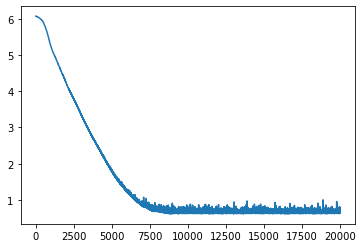

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/40 cores)
    finished (0:00:04) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scNT_pojection.png


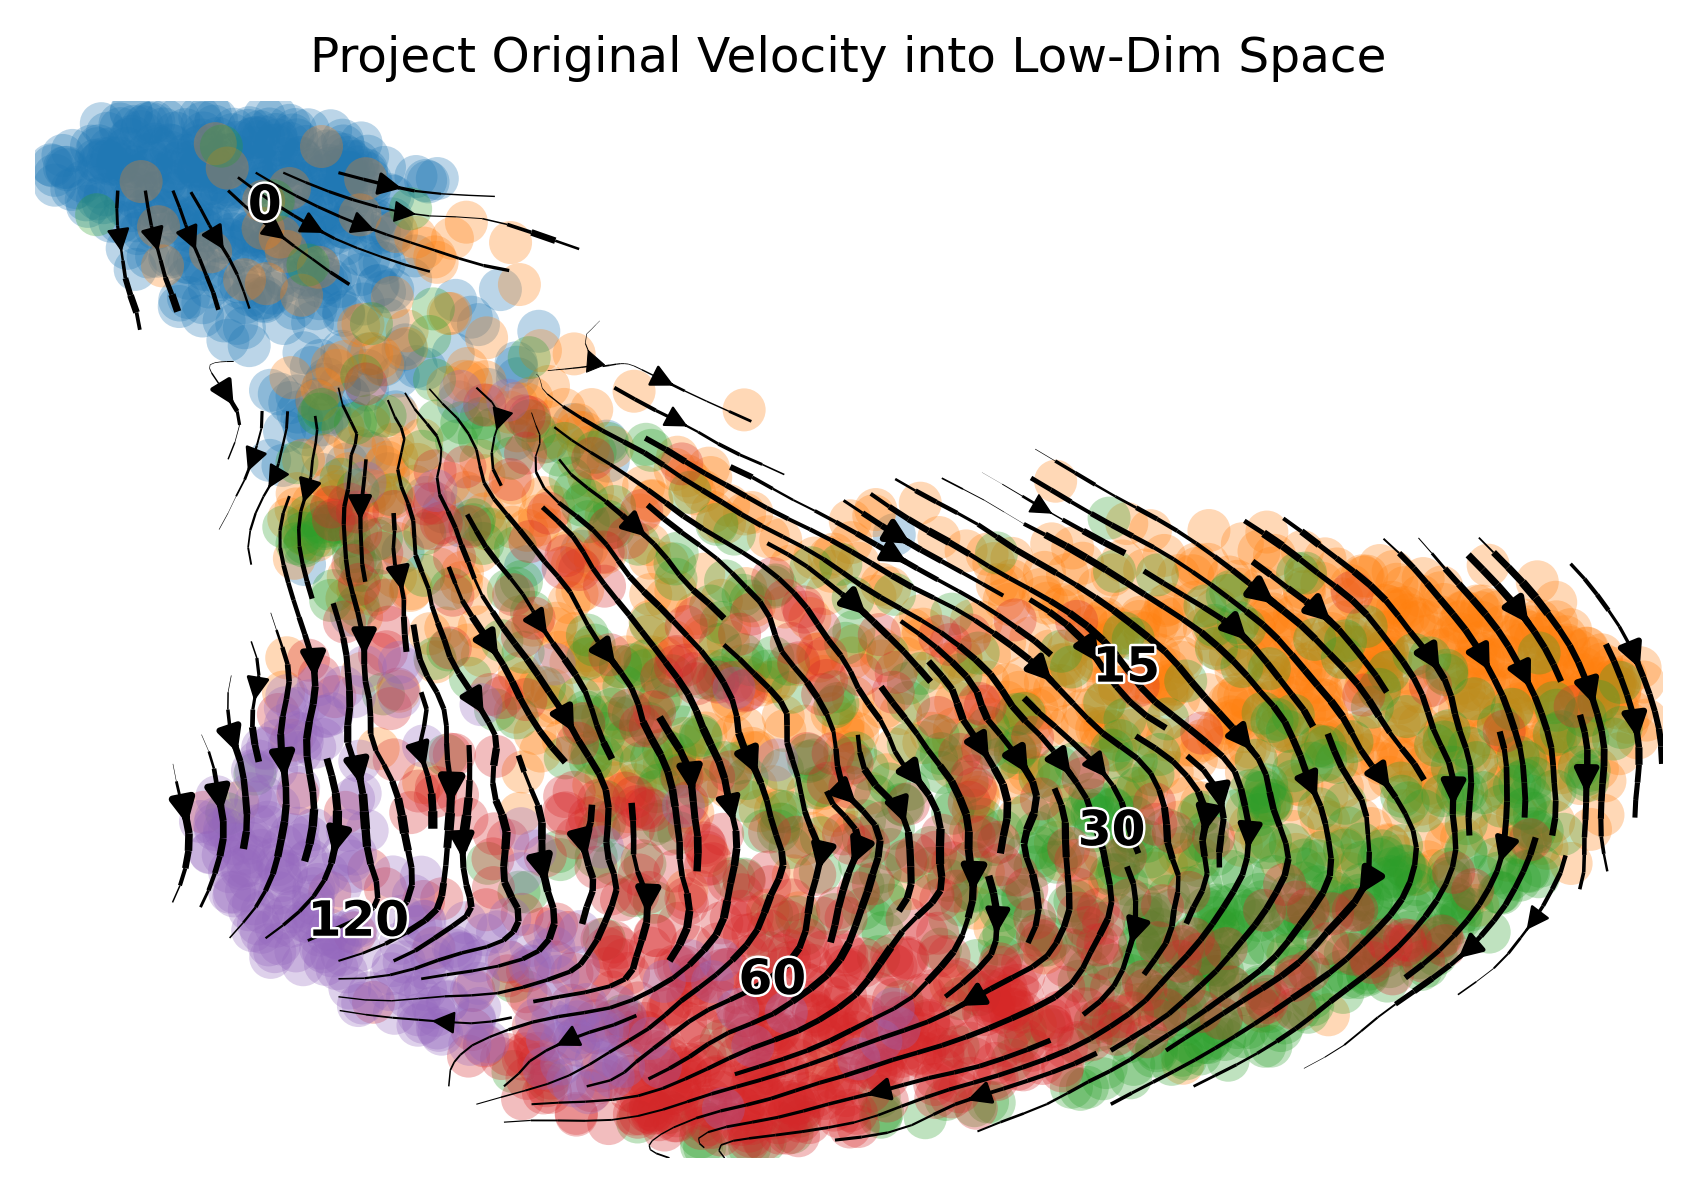

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.68253016, ('15', '30'): 0.68761396, ('30', '60'): 0.6681376, ('60', '120'): 0.68640506}
Total Mean: 0.6811716556549072
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9999816, ('15', '30'): 0.99998236, ('30', '60'): 0.9999689, ('60', '120'): 0.9999651}
Total Mean: 0.9999744892120361
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.5721079575942507, ('15', '30'): 0.4084363521285964, ('30', '60'): 0.28356601529891173, ('60', '120'): 0.2792208560502267}
Total Mean: 0.3858327952679964
# In-cluster Coherence
{'0': 0.9999853, '120': 0.9999811, '15': 0.9999847, '30': 0.99998313, '60': 0.99997324}
Total Mean: 0.9999815225601196
# In-cluster Confidence
{'0': 0.9999823848939848, '120': 0.9999717407492528, '15': 0.9999832787438837, '30': 0.9999800114704605, '60': 0.999

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred
                                 ).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['time'],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='scNT_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
exp(adata, exp_metrics)

In [10]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)